In [1]:
#Basic
import pandas as pd
import numpy as np
from google.cloud import bigquery, bigquery_storage
from datetime import date
from utils import *
from features import *
import random 

RANDOM_STATE = 12345
random.seed(RANDOM_STATE)

#Sklearn
pd.set_option('display.max_columns', None)
from sklearn import model_selection, preprocessing, pipeline, ensemble, calibration, metrics
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

#plotting
import matplotlib.pyplot as plt

#Custom loss functions
import keras.backend as K
from loss_function import *

#ALgorithms
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import InstanceHardnessThreshold

from xgboost import XGBClassifier
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from BorutaShap import BorutaShap

import warnings
warnings.filterwarnings("ignore") 

In [2]:
## content, GA and Sentiment
query = """
    WITH 
    ga_data AS (
        SELECT
            GA_fullVisitorId,
            GA_visitStartTime, 
            GA_date,
            GA_pagePath,
            GA_dfpNewZone,
            GA_visitNumber,
            GA_pageViews,
            GA_scrollDepth,
            timeOnPage,  
            GA_cmsNaturalId,
            GA_deviceOperatingSystem,
            GA_deviceCategory,
            GA_deviceBrowser,
            GA_country,
            GA_referralGroup,
            GA_primaryChannel,
            GA_primarySection
        FROM
            `api-project-901373404215.DataMart.v_DataMart_updated`
        WHERE
            ga_date BETWEEN '2022-02-01' and '2022-04-30'
    ),
    
    sampled_fullvids AS (
        SELECT
            GA_fullVisitorId
        FROM (
            SELECT
                GA_fullVisitorId,
                RAND() as rand
            FROM
                `api-project-901373404215.DataMart.v_DataMart_updated`
            WHERE
                DATE(ga_date) BETWEEN '2022-02-01' and '2022-04-30'
        )
        ORDER BY rand
        LIMIT 100000
    ),
    sentiment as
    (
    SELECT * EXCEPT (rank)
        FROM
    (
    SELECT 
          lower(natid) as sentiment_natid,
          pub_date, 
          clean_body, 
          sentiment_score,
          RANK() OVER (PARTITION BY natid ORDER BY pub_date DESC) AS rank
    FROM 
      `api-project-901373404215.sentiment.article_sentiment`
    )
    WHERE
           rank = 1 ),
    content_t AS (
        SELECT
            content_t.natid AS content_natid,
            publish_date,
            title,
            body,
            iab_cat_t.tier1
        FROM (
            SELECT 
                natid,
                EXTRACT(DATE FROM date_et) AS publish_date,
                title,
                body
            FROM (
                SELECT DISTINCT
                DATETIME(date, "America/New_York") as date_et,
                title,
                body,
                LOWER(NaturalId) AS natid,
                RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent
            FROM
                `api-project-901373404215.Content.content`
            WHERE
                Visible is true
                    AND type in (
                    'blog',
                    'blogslide',
                    'magazine'
                )
            )
        WHERE 
            mostrecent = 1
        ) AS content_t
        INNER JOIN (
            SELECT
                * EXCEPT (rank)
            FROM (
                SELECT DISTINCT
                    category AS tier1,
                    natid,
                    RANK() OVER (PARTITION BY natid ORDER BY ts DESC) AS rank
                FROM
                    `api-project-901373404215.DataMart.iab_cat_v2` 
            )
        WHERE
            rank = 1
        ) AS iab_cat_t
    ON 
        LOWER(iab_cat_t.natid) = LOWER(content_t.natid)
    ),
ga_content as 
    (
    SELECT
        GA_date,
        GA_fullVisitorId, 
        GA_visitStartTime,
        GA_visitNumber,
        GA_cmsNaturalId,
        publish_date,
        title,
        body,
        tier1,
        GA_pagePath,
        GA_dfpNewZone,
        timeOnPage,
        GA_scrollDepth,
        GA_pageViews,
        GA_deviceOperatingSystem,
        GA_deviceCategory,
        GA_deviceBrowser,
        GA_country,
        GA_referralGroup,
        GA_primaryChannel,
        GA_primarySection
    FROM
        ga_data
    
    LEFT OUTER JOIN
        content_t
    ON 
        LOWER(GA_cmsNaturalId) = LOWER(content_natid)
    WHERE
        GA_fullVisitorId IN (SELECT DISTINCT GA_fullVisitorId FROM sampled_fullvids)  #remove where condition for production
)

SELECT 
    GA_date,
        GA_fullVisitorId, 
        GA_visitStartTime,
        GA_visitNumber,
        GA_cmsNaturalId,
        publish_date,
        title,
        body,
        clean_body,
        sentiment_score,
        tier1,
        GA_pagePath,
        GA_dfpNewZone,
        timeOnPage,
        GA_scrollDepth,
        GA_pageViews,
        GA_deviceOperatingSystem,
        GA_deviceCategory,
        GA_deviceBrowser,
        GA_country,
        GA_referralGroup,
        GA_primaryChannel,
        GA_primarySection
    FROM
        ga_content
    
    LEFT OUTER JOIN
        sentiment
    ON 
        LOWER(GA_cmsNaturalId) = LOWER(sentiment_natid)
    WHERE                                 #not including ga_fullvisitorid from zoominfo labels
        GA_fullVisitorId NOT IN (
          SELECT 
            DISTINCT GA_fullVisitorId 
          FROM 
              `api-project-901373404215.lookalike_data.zoominfo_labels`         )
    """

#subscriber data
query_sub= """
    WITH 
    active_subs AS (
        SELECT DISTINCT
                user_id_uid
        FROM
            `api-project-901373404215.piano.subscriber_details`
        WHERE
            # Filter for the 'universal' subscriptions only
            resource_id_rid IN UNNEST(['RKPEVDB', 'R8W03AS'])
            AND status='active'
            AND total__refunded<1
    ),
    -- Join with the datamart to get the ga fullvid
    sub_fullvids AS (
        SELECT DISTINCT
            ga_fullvisitorid
        FROM
            active_subs
        INNER JOIN
            `api-project-901373404215.DataMart.v_DataMart_updated`
        ON
            LOWER(ga_pianoId) = LOWER(user_id_uid)
    )
    -- Create a flag for subscribers based off the ga fullvid
    SELECT
        *
    FROM
        sub_fullvids
    """

In [3]:
## Fetching data

bqclient = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

#GA_Content_Sentiment
df = bqclient.query(query).result().to_dataframe(bqstorage_client=bqstorageclient)
print(df.shape)

#Subscriber data

sub = bqclient.query(query_sub).to_dataframe()
print(sub.shape)

(2321449, 23)
(205509, 1)


In [4]:
df.head()

,GA_date,GA_fullVisitorId,GA_visitStartTime,GA_visitNumber,GA_cmsNaturalId,publish_date,title,body,clean_body,sentiment_score,tier1,GA_pagePath,GA_dfpNewZone,timeOnPage,GA_scrollDepth,GA_pageViews,GA_deviceOperatingSystem,GA_deviceCategory,GA_deviceBrowser,GA_country,GA_referralGroup,GA_primaryChannel,GA_primarySection
0,2022-04-08,8980389503593074699,1649405947,2,none,None,None,None,None,NaN,None,/home_asia/,none,600.0,0.70,1,linux,desktop,chrome,south africa,organic search,home,none
1,2022-04-16,2973391309305904117,1650109346,207,none,None,None,None,None,NaN,None,/sites/forbeshumanresourcescouncil/2022/04/12/...,none,234.0,0.00,1,windows,desktop,chrome,japan,direct,404,none
2,2022-04-11,11582845107001135371,1649717679,193,none,None,None,None,None,NaN,None,/profile/john-bicket/,none,10.0,0.25,1,android,mobile,chrome,albania,organic search,none,none
3,2022-04-29,7091481380907798421,1651238939,2767,none,None,None,None,None,NaN,None,/profile/fang-xiaoliang/,none,5.0,0.00,1,ios,desktop,safari,saudi arabia,organic search,none,none
4,2022-03-25,12853207401973024592,1648235934,182,none,None,None,None,None,NaN,None,/profile/rafal-brzoska/,none,274.0,0.25,1,android,mobile,chrome,russia,referral,none,none


In [5]:
len(df.GA_fullVisitorId.unique())

99254

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321449 entries, 0 to 2321448
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   GA_date                   object 
 1   GA_fullVisitorId          object 
 2   GA_visitStartTime         int64  
 3   GA_visitNumber            int64  
 4   GA_cmsNaturalId           object 
 5   publish_date              object 
 6   title                     object 
 7   body                      object 
 8   clean_body                object 
 9   sentiment_score           float64
 10  tier1                     object 
 11  GA_pagePath               object 
 12  GA_dfpNewZone             object 
 13  timeOnPage                float64
 14  GA_scrollDepth            float64
 15  GA_pageViews              int64  
 16  GA_deviceOperatingSystem  object 
 17  GA_deviceCategory         object 
 18  GA_deviceBrowser          object 
 19  GA_country                object 
 20  GA_referralGroup        

In [7]:
#Newsletter Unsubscription

nl = df.loc[df['GA_pagePath'].str.contains("newsletter/unsubscribe-confirmation", case=False)]
nl_unsub=nl.GA_fullVisitorId.unique().tolist()
len(nl_unsub)

22

In [8]:
#creating a subscribers list
sub_list=sub.ga_fullvisitorid.values.tolist()
len(sub_list)

205509

In [9]:
# Transform the user features
df_trans = get_user_feats(df)
df_trans.shape

(99254, 196)

In [10]:
df_trans.head()

,GA_fullVisitorId,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,sentiment_score_mean,sentiment_score_median,rf_content_aggregators,rf_direct,rf_fbia,rf_newsletter,rf_organic_search,rf_organic_social__dark,rf_organic_social__forbes,rf_paid_display,rf_paid_search,rf_paid_social__dark,rf_paid_web,rf_push_notification,rf_referral,ct_australia,ct_canada,ct_hong_kong,ct_india,ct_japan,ct_malaysia,ct_other,ct_philippines,ct_russia,ct_saudi_arabia,ct_singapore,ct_south_africa,ct_south_korea,ct_united_arab_emirates,ct_united_kingdom,ct_united_states,dos__not_set,dos_android,dos_blackberry,dos_chrome_os,dos_ios,dos_linux,dos_macintosh,dos_netbsd,dos_nokia,dos_os2,dos_playstation_4,dos_tizen,dos_windows,dos_windows_phone,dos_xbox,t1_automotive,t1_books_and_literature,t1_business_and_finance,t1_careers,t1_education,t1_fine_art,t1_food_and_drink,t1_healthy_living,t1_medical_health,t1_movies,t1_music_and_audio,t1_news_and_politics,t1_personal_finance,t1_real_estate,t1_science,t1_shopping,t1_sports,t1_style_and_fashion,t1_technology_and_computing,t1_television,t1_travel,t1_video_gaming,t1_other,t1_automotive_perc_pvs,t1_books_and_literature_perc_pvs,t1_business_and_finance_perc_pvs,t1_careers_perc_pvs,t1_education_perc_pvs,t1_fine_art_perc_pvs,t1_food_and_drink_perc_pvs,t1_healthy_living_perc_pvs,t1_medical_health_perc_pvs,t1_movies_perc_pvs,t1_music_and_audio_perc_pvs,t1_news_and_politics_perc_pvs,t1_personal_finance_perc_pvs,t1_real_estate_perc_pvs,t1_science_perc_pvs,t1_shopping_perc_pvs,t1_sports_perc_pvs,t1_style_and_fashion_perc_pvs,t1_technology_and_computing_perc_pvs,t1_television_perc_pvs,t1_travel_perc_pvs,t1_video_gaming_perc_pvs,t1_other_perc_pvs,pc_404,pc_asia,pc_billionaires,pc_business,pc_entrepreneurs,pc_forbes_magazine,pc_forbes_vetted,pc_home,pc_innovation,pc_leadership,pc_lifestyle,pc_money,pc_none,pc_other,pc_real_estate,pc_small_business,ps_aerospace_and_defense_pvs,ps_careers_pvs,ps_consumer_tech_pvs,ps_crypto_and_blockchain_pvs,ps_etfs_and_mutual_funds_pvs,ps_forbes_asia_pvs,ps_games_pvs,ps_hollywood_and_entertainment_pvs,ps_investing_pvs,ps_markets_pvs,ps_none_pvs,ps_other_pvs,ps_personal_finance_pvs,ps_retirement_pvs,ps_rtb_pvs,ps_style_and_beauty_pvs,t1_automotive_top,t1_books_and_literature_top,t1_business_and_finance_top,t1_careers_top,t1_education_top,t1_fine_art_top,t1_food_and_drink_top,t1_healthy_living_top,t1_medical_health_top,t1_movies_top,t1_music_and_audio_top,t1_news_and_politics_top,t1_personal_finance_top,t1_real_estate_top,t1_science_top,t1_shopping_top,t1_sports_top,t1_style_and_fashion_top,t1_technology_and_computing_top,t1_television_top,t1_travel_top,t1_video_gaming_top,t1_other_top,bounce_rate,content_views_rate,weekend_top,weekday_top,business_hours_top,non_business_hours_top,friday_top,monday_top,saturday_top,sunday_top,thursday_top,tuesday_top,wednesday_top,day_of_mon_1_top,day_of_mon_2_top,day_of_mon_3_top,day_of_mon_4_top,day_of_mon_5_top,day_of_mon_6_top,day_of_mon_7_top,day_of_mon_8_top,day_of_mon_9_top,day_of_mon_10_top,day_of_mon_11_top,day_of_mon_12_top,day_of_mon_13_top,day_of_mon_14_top,day_of_mon_15_top,day_of_mon_16_top,day_of_mon_17_top,day_of_mon_18_top,day_of_mon_19_top,day_of_mon_20_top,day_of_mon_21_top,day_of_mon_22_top,day_of_mon_23_top,day_of_mon_24_top,day_of_mon_25_top,day_of_mon_26_top,day_of_mon_27_top,day_of_mon_28_top,day_of_mon_29_top,day_of_mon_30_top,day_of_mon_31_top
0,10000354704691566393,1.0,1.0,38.444444,2.0,-0.123330,-0.098322,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.333333,0

In [11]:
#create a new feature "Newsletter subscriber"
df_trans['nl_subscription']=np.where(df_trans['GA_fullVisitorId'].isin (nl_unsub), 'nl_unsubscriber', 'nl_subscriber')

In [12]:
#create a new feature "subscriber"
df_trans['subscriber']=np.where(df_trans['GA_fullVisitorId'].isin (sub_list), 'subscriber', 'non_subscriber')

In [13]:
# Dropping Duplicates
df_trans.drop_duplicates(subset=['GA_fullVisitorId'],inplace=True)
df_trans.shape

(99254, 198)

In [14]:
#lower case column names
df_trans.columns= df_trans.columns.str.lower()

In [15]:
df_trans.head()

,ga_fullvisitorid,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,sentiment_score_mean,sentiment_score_median,rf_content_aggregators,rf_direct,rf_fbia,rf_newsletter,rf_organic_search,rf_organic_social__dark,rf_organic_social__forbes,rf_paid_display,rf_paid_search,rf_paid_social__dark,rf_paid_web,rf_push_notification,rf_referral,ct_australia,ct_canada,ct_hong_kong,ct_india,ct_japan,ct_malaysia,ct_other,ct_philippines,ct_russia,ct_saudi_arabia,ct_singapore,ct_south_africa,ct_south_korea,ct_united_arab_emirates,ct_united_kingdom,ct_united_states,dos__not_set,dos_android,dos_blackberry,dos_chrome_os,dos_ios,dos_linux,dos_macintosh,dos_netbsd,dos_nokia,dos_os2,dos_playstation_4,dos_tizen,dos_windows,dos_windows_phone,dos_xbox,t1_automotive,t1_books_and_literature,t1_business_and_finance,t1_careers,t1_education,t1_fine_art,t1_food_and_drink,t1_healthy_living,t1_medical_health,t1_movies,t1_music_and_audio,t1_news_and_politics,t1_personal_finance,t1_real_estate,t1_science,t1_shopping,t1_sports,t1_style_and_fashion,t1_technology_and_computing,t1_television,t1_travel,t1_video_gaming,t1_other,t1_automotive_perc_pvs,t1_books_and_literature_perc_pvs,t1_business_and_finance_perc_pvs,t1_careers_perc_pvs,t1_education_perc_pvs,t1_fine_art_perc_pvs,t1_food_and_drink_perc_pvs,t1_healthy_living_perc_pvs,t1_medical_health_perc_pvs,t1_movies_perc_pvs,t1_music_and_audio_perc_pvs,t1_news_and_politics_perc_pvs,t1_personal_finance_perc_pvs,t1_real_estate_perc_pvs,t1_science_perc_pvs,t1_shopping_perc_pvs,t1_sports_perc_pvs,t1_style_and_fashion_perc_pvs,t1_technology_and_computing_perc_pvs,t1_television_perc_pvs,t1_travel_perc_pvs,t1_video_gaming_perc_pvs,t1_other_perc_pvs,pc_404,pc_asia,pc_billionaires,pc_business,pc_entrepreneurs,pc_forbes_magazine,pc_forbes_vetted,pc_home,pc_innovation,pc_leadership,pc_lifestyle,pc_money,pc_none,pc_other,pc_real_estate,pc_small_business,ps_aerospace_and_defense_pvs,ps_careers_pvs,ps_consumer_tech_pvs,ps_crypto_and_blockchain_pvs,ps_etfs_and_mutual_funds_pvs,ps_forbes_asia_pvs,ps_games_pvs,ps_hollywood_and_entertainment_pvs,ps_investing_pvs,ps_markets_pvs,ps_none_pvs,ps_other_pvs,ps_personal_finance_pvs,ps_retirement_pvs,ps_rtb_pvs,ps_style_and_beauty_pvs,t1_automotive_top,t1_books_and_literature_top,t1_business_and_finance_top,t1_careers_top,t1_education_top,t1_fine_art_top,t1_food_and_drink_top,t1_healthy_living_top,t1_medical_health_top,t1_movies_top,t1_music_and_audio_top,t1_news_and_politics_top,t1_personal_finance_top,t1_real_estate_top,t1_science_top,t1_shopping_top,t1_sports_top,t1_style_and_fashion_top,t1_technology_and_computing_top,t1_television_top,t1_travel_top,t1_video_gaming_top,t1_other_top,bounce_rate,content_views_rate,weekend_top,weekday_top,business_hours_top,non_business_hours_top,friday_top,monday_top,saturday_top,sunday_top,thursday_top,tuesday_top,wednesday_top,day_of_mon_1_top,day_of_mon_2_top,day_of_mon_3_top,day_of_mon_4_top,day_of_mon_5_top,day_of_mon_6_top,day_of_mon_7_top,day_of_mon_8_top,day_of_mon_9_top,day_of_mon_10_top,day_of_mon_11_top,day_of_mon_12_top,day_of_mon_13_top,day_of_mon_14_top,day_of_mon_15_top,day_of_mon_16_top,day_of_mon_17_top,day_of_mon_18_top,day_of_mon_19_top,day_of_mon_20_top,day_of_mon_21_top,day_of_mon_22_top,day_of_mon_23_top,day_of_mon_24_top,day_of_mon_25_top,day_of_mon_26_top,day_of_mon_27_top,day_of_mon_28_top,day_of_mon_29_top,day_of_mon_30_top,day_of_mon_31_top,nl_subscription,subscriber
0,10000354704691566393,1.0,1.0,38.444444,2.0,-0.123330,-0.098322,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [24]:
# c=0
# for i in df.GA_fullVisitorId.unique().tolist():
#     if i in df_trans.ga_fullvisitorid.tolist():
#         c+=1
# c

998

In [12]:
# # Upload to BQ
# DATASET_ID = 'lookalike_trail_data'
# TABLE_ID = 'sample_prediction_data_feb_april'

# upload_bq(
#     dataset_id=DATASET_ID,
#     table_id=TABLE_ID,
#     df=df_trans,
#     write_truncate=True # Will overwrite current table
# )

sample_prediction_data_feb_april loaded into BQ


In [2]:
query="""
    SELECT * 
    FROM `api-project-901373404215.lookalike_trail_data.sample_prediction_data_feb_april`
"""

In [3]:
## Fetching data

bqclient = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

#GA_Content_Sentiment
df_trans = bqclient.query(query).result().to_dataframe(bqstorage_client=bqstorageclient)
print(df_trans.shape)

(99261, 197)


In [4]:
#Taking Full Visitor ID
ga_fullvisitorid = df_trans['ga_fullvisitorid']
len(ga_fullvisitorid)

99261

In [5]:
#dropping ga_fullvisitorid
df_trans=df_trans.drop(columns=['ga_fullvisitorid'],axis=1)
df_trans.shape

(99261, 196)

In [6]:
#Fetching Categorical Featuresz
cat=[]
for column in df_trans.columns:
    if df_trans[column].dtypes == 'object':
        cat.append(column)
cat

['nl_subscription', 'subscriber']

In [7]:

#Encoding Categorical Features
label_encoder = preprocessing.LabelEncoder()

for column in cat:
    df_trans[column]=label_encoder.fit_transform(df_trans[column])
df_trans.shape

(99261, 196)

In [39]:
#Loading Features and models

features = pd.read_pickle('features.pkl')
model = pd.read_pickle('model.pkl')
calibrated_model = pd.read_pickle('calibrated_model.pkl')

In [40]:
#Since we noticed some features might be missing from the test set, checking and creating those features manually
missing_feats = []
for i in features:
    if i not in df_trans.columns:
        missing_feats.append(i)
print(missing_feats)

#If we have missing features, we create those with value = 0
if len(missing_feats) !=0:
    for feature in missing_feats:
        df_trans[feature]= 0   ### Zero 


[]


In [46]:
#prediction
X_data=df_trans[features]
predicted_label = calibrated_model.predict(X_data)
predicted_probability =calibrated_model.predict_proba(X_data)
pred_prob = predicted_probability[:,1]


In [47]:
result = pd.DataFrame({'ga_fullvisitorid': ga_fullvisitorid, 'probability':pred_prob,'predicted':predicted_label})

In [48]:
result.head()

,ga_fullvisitorid,probability,predicted
0,10782738901012816667,0.270142,0
1,1118303348295156810,0.136642,0
2,12527153147817785502,0.265432,0
3,1868168491726885659,0.238597,0
4,2980346128385169225,0.199793,0


In [49]:
result.predicted.value_counts(normalize=True)

0    0.992827
1    0.007173
Name: predicted, dtype: float64

<AxesSubplot:>

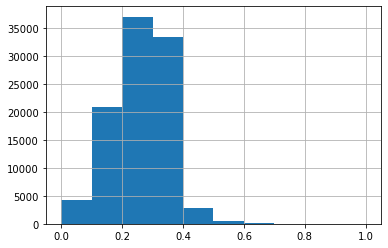

In [50]:
result.probability.hist()

In [51]:
# # Upload to BQ
DATASET_ID = 'lookalike_trail_data'
TABLE_ID = 'sample_predicted_feb_april_new'

upload_bq(
    dataset_id=DATASET_ID,
    table_id=TABLE_ID,
    df=result,
    write_truncate=True # Will overwrite current table
)

sample_predicted_feb_april_new loaded into BQ
